In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams.update({'font.size': 8})



In [13]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def get_mode_insertion_data(env_path, data):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:,0], mode_insert_set])
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))


        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
        has_mode_insert_data = False
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:-1,0], mode_insert_set])
            has_mode_insert_data = True
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
#         _y = pull_max(data_set[:,1])
        _y = data_set[:,1]

        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)

    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    
    if has_mode_insert_data:
        mi_interp_data = []
        for data_set in mode_insert_data:
            _x = data_set[0]
            _y = data_set[1]
            mi_interp_data.append(np.interp(x_samples, _x, _y))
        mi_mean = np.mean(mi_interp_data, axis=0)
        mi_max = np.max(mi_interp_data, axis=0)
        mi_min = np.min(mi_interp_data, axis=0)

        data_log.update({'mode_insert' : mi_mean,
                         'mi_min': mi_min,
                         'mi_max' : mi_max})

#     _data = np.stack(interp_data)
#     d = np.abs(_data - np.median(_data, axis=0, keepdims=True))
#     mdev = np.median(d, axis=0, keepdims=True)
#     s = d/(mdev if mdev.all() else 1)
#     idxs = s < 2
#     mean = []
#     std  = []
#     for i in range(idxs.shape[1]):
#         mean.append(np.mean(_data[idxs[:,i], i]))
#         std.append(np.std(_data[idxs[:,i], i]))
    

    return data_log

def plot_data(ax, log, label):
    ax.plot(log['x'], log['mean'], label=label)
    ax.fill_between(log['x'], 
                    log['-std'], log['+std'],
                    alpha=0.2)


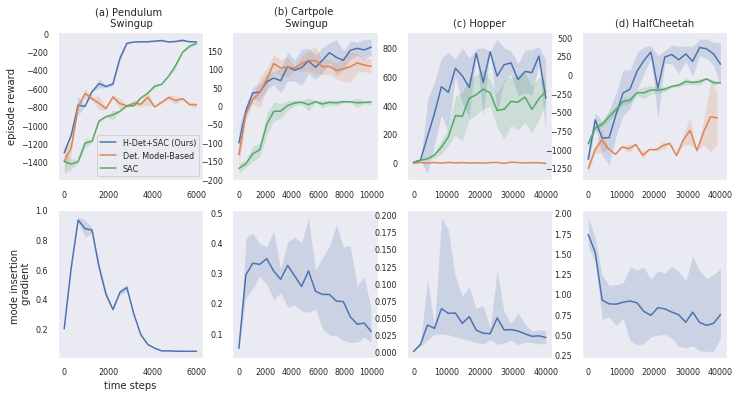

In [14]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(2, 4, figsize=(12,6))

env_list = ['PendulumEnv', 'InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

for i,env in enumerate(env_list):
    hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
    hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
    sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

    stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
    deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


#     plot_data(axs[0,i], hsac_data, 'HStoc-SAC')
    plot_data(axs[0,i], hdsac_data, 'H-Det+SAC (Ours)')
#     plot_data(axs[0,i], stoch_model_data, 'Stoch-ModelBased')
    plot_data(axs[0,i], deter_model_data, 'Det. Model-Based')
    plot_data(axs[0,i], sac_data, 'SAC')
        

    axs[0,i].set_title(names[env], fontsize=10)
    
    axs[0,i].tick_params(axis='both', which='major', labelsize=8)
#     axs[i].tick_params(axis='both', which='minor', labelsize=10)
    axs[1,i].tick_params(axis='both', which='major', labelsize=8)

    
    axs[1,i].plot(hdsac_data['x'],hdsac_data['mode_insert'])
    axs[1,i].fill_between(hdsac_data['x'], 
                    hdsac_data['mi_min'], hdsac_data['mi_max'],
                    alpha=0.2)
    
    
axs[1,0].set_xlabel('time steps', fontsize=10)
axs[0,0].set_ylabel('episode reward', fontsize=10)
axs[0,0].legend(fontsize=8)

axs[1,0].set_ylabel('mode insertion \n gradient', fontsize=10)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

plt.savefig('deterministic_benchmark_results.pdf')


In [15]:
env = 'InvertedPendulumSwingupBulletEnv'
hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


plot_data(axs[i], hsac_data, 'H-Stoc+SAC (Ours)')
#     plot_data(axs[i], hdsac_data, 'H-Det+SAC (Ours)')
plot_data(axs[i], stoch_model_data, 'Stoch. Model-Based')
#     plot_data(axs[i], deter_model_data, 'Det. Model-Based')
plot_data(axs[i], sac_data, 'SAC')
        

IndexError: index 3 is out of bounds for axis 0 with size 2

In [16]:
pickle.dump(stoch_model_data, open('model_policy_analysis/data/InvertedPendulumSwingupBulletEnv/model_based_results/data.pkl', 'wb'))
pickle.dump(sac_data, open('model_policy_analysis/data/InvertedPendulumSwingupBulletEnv/model_free_results/data.pkl', 'wb'))


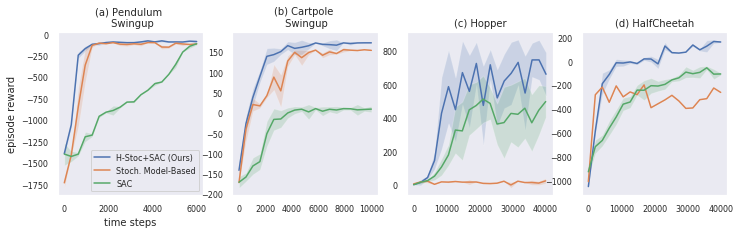

In [17]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(1, 4, figsize=(12,3))

env_list = ['PendulumEnv', 'InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

for i,env in enumerate(env_list):
    hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
    hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
    sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

    stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
    deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


    plot_data(axs[i], hsac_data, 'H-Stoc+SAC (Ours)')
#     plot_data(axs[i], hdsac_data, 'H-Det+SAC (Ours)')
    plot_data(axs[i], stoch_model_data, 'Stoch. Model-Based')
#     plot_data(axs[i], deter_model_data, 'Det. Model-Based')
    plot_data(axs[i], sac_data, 'SAC')
        

    axs[i].set_title(names[env], fontsize=10)
    
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    
    
axs[0].set_xlabel('time steps', fontsize=10)
axs[0].set_ylabel('episode reward', fontsize=10)
axs[0].legend(fontsize=8)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

plt.savefig('stochastic_benchmark_results.pdf')


In [18]:
_rew = None
new_mean = []
for m in sac_data['mean']:
    if _rew is None:
        _rew = m
    else:
        if m > _rew:
            _rew = m
    new_mean.append(_rew)

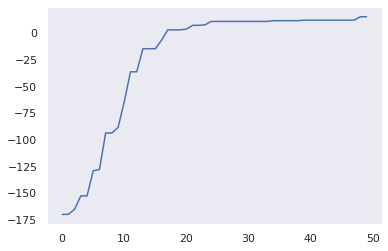

In [6]:
plt.plot(new_mean)

Imitation Learning
==================

In [3]:
data = []
for path in glob.glob('benchmarks/data/AntBulletEnv/bc/*/reward_data.pkl'):
    data.append(
        pickle.load(open(path, 'rb'))
    )
    
hybrid_data = []
for path in glob.glob('benchmarks/data/AntBulletEnv/boot_strapped_bc/*/reward_data.pkl'):
    hybrid_data.append(
        pickle.load(open(path, 'rb'))
    )

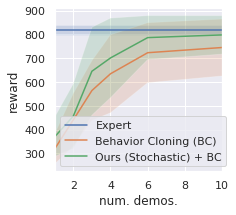

In [7]:
plt.figure(figsize=(3,3))

idxs = [0,1,2,3,5,9,10,14]
demos = np.array(idxs)+1

expert_rew = np.array([818.19 for i in range(len(idxs))])
expert_std = np.array([19.86 for i in range(len(idxs))])

plt.plot(demos, expert_rew, label='Expert')
plt.fill_between(demos, expert_rew-expert_std, expert_rew+expert_std, alpha=0.2)



mean_data = np.mean(data, axis=0)
std = np.std(data,axis=0)[idxs,1]
x = mean_data[idxs,0]
# x = np.arange(1,len(x))
y = mean_data[idxs,1]

plt.plot(demos,y, label='Behavior Cloning (BC)')

plt.fill_between(demos, y-std, y+std, alpha=0.2)

mean_data = np.mean(hybrid_data, axis=0)
std = np.std(hybrid_data,axis=0)[idxs,1]

x = mean_data[idxs,0]
# x = np.arange(1,len(x))

y = mean_data[idxs,1]
plt.plot(demos,y, label='Ours (Stochastic) + BC')
plt.fill_between(demos, y-std, y+std, alpha=0.2)

plt.xlabel('num. demos.')
plt.ylabel('reward')

plt.xlim(1,10)

plt.legend()
plt.savefig('ant_results.pdf')

In [101]:
np.std(hybrid_data,axis=0)

array([[  0.        ,  82.82242797],
       [  0.        , 135.72289954],
       [  0.        , 184.60921549],
       [  0.        , 167.09161074],
       [  0.        , 149.60611474],
       [  0.        ,  92.17326237],
       [  0.        ,  90.03920898],
       [  0.        , 109.86786287],
       [  0.        ,  95.1889665 ],
       [  0.        ,  80.68524366],
       [  0.        ,  88.5186579 ],
       [  0.        , 113.2901006 ],
       [  0.        ,  84.89827349],
       [  0.        , 118.54429844],
       [  0.        ,  99.71347554]])